## Main regression analysis

This notebook loads all the data for the main regression analysis, combines the results into tables and visualizes the results

The `results_base_dir` in the code refer the results directories of all different combinations. Check `/src/data_analysis/run/run.sh` for the corresponding config files.

In [3]:
from distutils.core import setup

import pandas as pd
import numpy as np
import os
import json
import yaml
from collections import defaultdict
from sklearn import metrics as sk_metrics
from scipy.stats import spearmanr, pearsonr
from scipy.stats import bootstrap

from config.config import Config
from util.helpers import mean_absolute_percentile_error


In [4]:


# load directories from results dir that contain the results we're interested in
results_base_dir = [

    "/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw11/20250312_1245_1d8b_svr_reduced_feature_sets",
    "/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw11/20250312_1411_60f5_svr_reduced_feature_sets_train_test",
    "/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw11/20250312_1449_b08e_svr_reduced_feature_sets",
    "/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw11/20250312_1513_316f_svr_reduced_feature_sets_train_test",


]

results_dirs = [os.path.join(base) for base in results_base_dir if os.path.exists(os.path.join(base, "results.txt"))] + \
               [os.path.join(parent, dir) for base in results_base_dir for parent, dirs, _ in
                os.walk(os.path.join(base)) for dir in dirs if os.path.exists(os.path.join(parent, dir, "results.txt"))]


def spearman_correlation_metric(y_true, y_pred):
    return spearmanr(y_true, y_pred).statistic
def pearson_correlation_metric(y_true, y_pred):
    return pearsonr(y_true, y_pred).statistic
metrics = [
    #sk_metrics.explained_variance_score, 
    spearman_correlation_metric, 
    mean_absolute_percentile_error, 
    sk_metrics.r2_score, 
    #pearson_correlation_metric,
    sk_metrics.mean_absolute_error,
    #sk_metrics.mean_squared_error,
    #sk_metrics.mean_absolute_percentage_error
]

def calculate_test_union_scores(results_dir):
    prediction_and_target = pd.read_csv(os.path.join(results_dir, "prediction_and_target.csv"))
    target_variable = prediction_and_target.drop(columns=['split_idx', 'prediction', 'Unnamed: 0']).columns[0]
    predictions, targets = prediction_and_target['prediction'], prediction_and_target[target_variable]
    scores_overall = {}
    for metric in metrics:
        score = metric(targets, predictions)
        bootstrap_obj = bootstrap((targets, predictions), metric, n_resamples=1000, paired=True, random_state=123)
        bootstrap_ci = bootstrap_obj.confidence_interval
        scores_overall[metric.__name__] = {
            'score': score,
            'ci_low': bootstrap_ci.low,
            'ci_high': bootstrap_ci.high,
            'bootstrap_distribution': bootstrap_obj.bootstrap_distribution,
            'results_dir': results_dir,
        }
        
    return scores_overall


scores = defaultdict(lambda: [])
dirs = defaultdict(lambda: [])

for d in results_dirs:
    # prepare data for results analysis
    # go through all results dirs, extract relevant information from e.g. config file, and condense them in parameter_string, which identifies a unique set of settings
    basename = os.path.basename(d)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))

    try:
        target = config.config_model.target_variable
    except:
        target = None

    try:
        task = config.config_data.task
    except:
        task = None

    try:
        data_transformers = "+".join(config.data_transformers)
        if 'Demographic Features' in config.data_transformers:
            demographic_feature_groups = ['dem']
        else: 
            demographic_feature_groups = []

        data_transformers = data_transformers.replace("Linguistic Features", "Ling")
        data_transformers = data_transformers.replace("Audio Features", "Audio")
        data_transformers = data_transformers.replace("Demographic Features", "Demogr")
    except:
        data_transformers = ""
        demographic_feature_groups = []
    
    try:
        data_preprocessors = "+".join(config.data_preprocessors)
        data_preprocessors = data_preprocessors.replace("Outlier Removal and Imputation", "OutlierRemoval")
        data_preprocessors = data_preprocessors.replace("Feature Standardizer", "Stand")
    except:
        data_preprocessors = ""   
        
    try:
        model_name = config.config_model.model_name
    except:
        model_name = None

    if 'Linguistic Features' in config.data_transformers:
        try:
            if not 'Linguistic Features' in config.data_transformers:
                raise ValueError(f"Invalid config: No Linguistic Features (data transformers: {data_transformers}) but ", config.config_linguistic_features.feature_groups, "for dir", d)
            linguistic_feature_groups = config.config_linguistic_features.feature_groups
        except:
            linguistic_feature_groups = ['literature_features', 'csunghye_features']
    else:
        linguistic_feature_groups = []
        
    if 'Audio Features' in config.data_transformers:
        try:
            if not 'Audio Features' in config.data_transformers:
                raise ValueError(f"Invalid config: No Audio Features (data transformers: {data_transformers}) but ", config.config_linguistic_features.feature_groups, "for dir", d)
            audio_feature_groups = config.config_audio_features.feature_groups
        except:
            audio_feature_groups = ['pause_features', 'phoneme_features', 'opensmile_features']
    else:
        audio_feature_groups = []

    try:
        cv_splits = config.config_model.cv_splits
    except:
        cv_splits = None
        
    try:
        data_split = config.config_data.split
    except:
        data_split = None
        
    feature_groups = audio_feature_groups + linguistic_feature_groups + demographic_feature_groups
    feature_group_mapping = {'pause_features': 'pause', 'phoneme_features': 'phoneme', 'opensmile_features': 'eGeMAPS', 'literature_features': 'lit', 'LIWC_features': 'liwc', 'csunghye_features': 'csunghye'}
    feature_groups = [feature_group_mapping.get(f, f) for f in feature_groups]
    feature_groups_str = "|".join(feature_groups)
    
            
    
    if data_split == 'full' and cv_splits == 1:
        setup_version = 'train/test'
    elif data_split == 'full' and (cv_splits is None or cv_splits > 1):
        setup_version = 'CV full'
    elif (data_split == 'train' or data_split is None) and (cv_splits is None or cv_splits > 1):
        setup_version = 'CV train'
    else:
        setup_version = "unknown"

        
    parameter_string = f"{model_name} - {task} - {target} - {data_transformers} - {data_preprocessors} - {setup_version} - {feature_groups_str}"

    dirs[parameter_string].append(d)

    
    scores[parameter_string].append(calculate_test_union_scores(d))



print(*[f"{parameter_string}: {len(scores[parameter_string])} results ({str(dirs[parameter_string]) if len(scores[parameter_string]) > 1 else ''})" for parameter_string in scores], sep="\n")

KeyboardInterrupt: 

In [51]:
for parameter_string, res in scores.items():
    assert len(res) == 1, f"{len(res)} results for parameter_string {parameter_string}?"

In [52]:
scores[parameter_string][0].keys()


dict_keys(['spearman_correlation_metric', 'mean_absolute_percentile_error', 'r2_score', 'mean_absolute_error'])

In [59]:
import seaborn
import matplotlib.pyplot as plt

def plot_results(scores, metric):
    #metric = 'explained_variance_score'
    #metric = 'r2_score'
    #metric = 'mean_absolute_error'
    #metric = 'spearman_correlation_metric'
    data_to_plot = defaultdict(dict)
    annotation_to_plot = defaultdict(dict)
    non_plotting_dimensions_collected = list()
    ignore_dimensions_collected = list()
    for parameter_string in scores.keys():
        split_parameter_string = parameter_string.split(" - ")
        model_name, task, target, data_transformers, data_preprocessors, setup_version, feature_groups = split_parameter_string
        x_grouping = [target, setup_version]
        y_grouping = [model_name, feature_groups]
        ignore_dimensions = [data_transformers, data_preprocessors]  # can be different, but not in x_grouping / y_grouping
        x_grouping_str, y_grouping_str = "|".join(x_grouping), "|".join(y_grouping)
        
        y_grouping_str = y_grouping_str.replace("SVR|dem", "Demographic features").replace("SVR|lit|csunghye|dem", "Linguistic+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|dem", "Audio+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|lit|csunghye|dem", "Linguistic+Audio+Demographic features").replace("MeanPrediction|dem", "Baseline: Mean predictor").replace("RandomSampling|dem", "Baseline: Random")
        x_grouping_str = x_grouping_str.replace("composite_executive_function|CV train", "Executive function|CV Development set").replace("composite_language|CV train", "Language|CV Development set").replace("composite_memory|CV train", "Memory|CV Development set").replace("composite_speed|CV train", "Speed|CV Development set")
        x_grouping_str = x_grouping_str.replace("composite_executive_function|train/test", "Executive function|Holdout Test set").replace("composite_language|train/test", "Language|Holdout Test set").replace("composite_memory|train/test", "Memory|Holdout Test set").replace("composite_speed|train/test", "Speed|Holdout Test set")
        
        y_grouping_str = y_grouping_str.replace("CV train", "CV Development set").replace("train/test", "Holdout Test set")

        
        data_to_plot[x_grouping_str][y_grouping_str] = scores[parameter_string][0][metric]['score']
        if 'train/test' in parameter_string:
            # no confidence intervals for train/test
            annotation_to_plot[x_grouping_str][y_grouping_str] = f"{scores[parameter_string][0][metric]['score']:.2f}"
        else:
            annotation_to_plot[x_grouping_str][y_grouping_str] = f"{scores[parameter_string][0][metric]['score']:.2f} [{scores[parameter_string][0][metric]['ci_low']:.2f}, {scores[parameter_string][0][metric]['ci_high']:.2f}]"
            
        
        non_plotting_dimensions = [dim for dim in split_parameter_string if dim not in x_grouping + y_grouping + ignore_dimensions]
        non_plotting_dimensions_collected.append(non_plotting_dimensions)
        ignore_dimensions_collected.append(ignore_dimensions)
    
    
    non_plotting_dimensions_set = [set([row[i] for row in non_plotting_dimensions_collected]) for i in range(len(non_plotting_dimensions_collected[0]))]
    if any([len(dim) > 1 for dim in non_plotting_dimensions_set]):
        raise ValueError("Non-plotting dimensions should be the same in all settings, but they are not:", non_plotting_dimensions_set)
    ignore_dimensions_set = [set([row[i] for row in ignore_dimensions_collected]) for i in range(len(ignore_dimensions_collected[0]))]
    print(non_plotting_dimensions_set, ignore_dimensions_set)
    non_plotting_dimensions_str = " / ".join([str(dim) if len(dim)>1 else list(dim)[0] for dim in non_plotting_dimensions_set+ignore_dimensions_set])
    
    def custom_index_sort(indices):
        def map_index(idx):
            if 'Baseline' in idx: return 0
            else: return len(idx)
        sorted_indices = [map_index(idx) for idx in indices]
        return sorted_indices
    
    def custom_column_sort(col):
        if 'Executive function' in col:
            return 2
        elif 'Language' in col:
            return 1
        elif 'Memory' in col:
            return 4
        elif 'Speed' in col:
            return 3

    data_to_plot_df = pd.DataFrame(data_to_plot)
    print(data_to_plot_df.columns)
    data_to_plot_df = data_to_plot_df[sorted(data_to_plot_df.columns, key=custom_column_sort)].sort_index(key=custom_index_sort)
    #display(data_to_plot_df)
        
    annotation_to_plot_df = pd.DataFrame(annotation_to_plot)        
    annotation_to_plot_df = annotation_to_plot_df[sorted(annotation_to_plot_df.columns, key=custom_column_sort)].sort_index(key=custom_index_sort)
    annotation_to_plot_df.columns = pd.MultiIndex.from_tuples([tuple(c.split("|")) for c in annotation_to_plot_df.columns])
    display(annotation_to_plot_df)
    print(annotation_to_plot_df.to_latex())
    
    fig = plt.figure(figsize=(15,6))
    plt.rc('text', usetex=False)
    #seaborn.heatmap(data_to_plot_df, cmap='Blues', annot=True, cbar_kws={'label': metric})
    seaborn.heatmap(data_to_plot_df, cmap='Blues', annot=annotation_to_plot_df, fmt = '', annot_kws={"size":8}, cbar_kws={'label': metric})
    plt.title(f"Regression results ({metric})")
    fig.subplots_adjust(bottom=0.08)
    fig.text(0, 0.0, f"Setup: {non_plotting_dimensions_str}", wrap=True, horizontalalignment='left', fontsize=8)
    plt.tight_layout()
    plt.show()
    


[{'pictureDescription'}] [{'Ling+Audio+Demogr', 'Audio+Demogr', 'Demogr', 'Ling+Demogr'}, {'Stand', '', 'OutlierRemoval+Stand'}]
Index(['Executive function|CV Development set', 'Speed|CV Development set',
       'Memory|CV Development set', 'Language|CV Development set',
       'Speed|Holdout Test set', 'Memory|Holdout Test set',
       'Executive function|Holdout Test set', 'Language|Holdout Test set'],
      dtype='object')


Language                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               -0.00 [-0.00, -0.00]            -0.00   
Baseline: Random                       -1.08 [-1.32, -0.87]            -0.81   
Demographic features                      0.07 [0.03, 0.10]             0.08   
Audio+Demographic features                0.17 [0.12, 0.22]             0.17   
Linguistic+Demographic features           0.23 [0.18, 0.28]             0.24   
Linguistic+Audio+Demographic features     0.27 [0.22, 0.32]             0.29   

                                         Executive function                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor                -0.00 [-0.00, 0.00]            -0.03   
Baseline: Random                       -1.10 [-1.32, -0.90]            -1.30   
Demographic features                     0.03 [-0.00, 0.07]             0.05   
Audio+Demographic features                0.08 [0.03, 0.12]             0.09   
Linguistic+Demographic features           0.10 [0.05, 0.14]             0.18   
Linguistic+Audio+Demographic features     0.13 [0.09, 0.18]             0.20   

                                                      Speed                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               -0.00 [-0.00, -0.00]            -0.00   
Baseline: Random                       -0.85 [-1.07, -0.69]            -1.03   
Demographic features                    -0.00 [-0.04, 0.04]            -0.04   
Audio+Demographic features               0.04 [-0.02, 0.08]            -0.01   
Linguistic+Demographic features         -0.01 [-0.05, 0.03]             0.00   
Linguistic+Audio+Demographic features     0.05 [0.01, 0.09]             0.03   

                                                     Memory                   
                                         CV Development set Holdout Test set  
Baseline: Mean predictor               -0.00 [-0.00, -0.00]            -0.01  
Baseline: Random                       -1.10 [-1.35, -0.91]            -1.01  
Demographic features                     0.01 [-0.04, 0.05]             0.09  
Audio+Demographic features               0.01 [-0.04, 0.06]             0.03  
Linguistic+Demographic features          0.03 [-0.02, 0.09]             0.07  
Linguistic+Audio+Demographic features    0.04 [-0.00, 0.09]             0.07

\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{2}{r}{Language} & \multicolumn{2}{r}{Executive function} & \multicolumn{2}{r}{Speed} & \multicolumn{2}{r}{Memory} \\
 & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set \\
\midrule
Baseline: Mean predictor & -0.00 [-0.00, -0.00] & -0.00 & -0.00 [-0.00, 0.00] & -0.03 & -0.00 [-0.00, -0.00] & -0.00 & -0.00 [-0.00, -0.00] & -0.01 \\
Baseline: Random & -1.08 [-1.32, -0.87] & -0.81 & -1.10 [-1.32, -0.90] & -1.30 & -0.85 [-1.07, -0.69] & -1.03 & -1.10 [-1.35, -0.91] & -1.01 \\
Demographic features & 0.07 [0.03, 0.10] & 0.08 & 0.03 [-0.00, 0.07] & 0.05 & -0.00 [-0.04, 0.04] & -0.04 & 0.01 [-0.04, 0.05] & 0.09 \\
Audio+Demographic features & 0.17 [0.12, 0.22] & 0.17 & 0.08 [0.03, 0.12] & 0.09 & 0.04 [-0.02, 0.08] & -0.01 & 0.01 [-0.04, 0.06] & 0.03 \\
Linguistic+Demographic features & 0.23 [0.18, 0.28] & 0.24 & 0.10 [0.05, 0.14] & 0.18

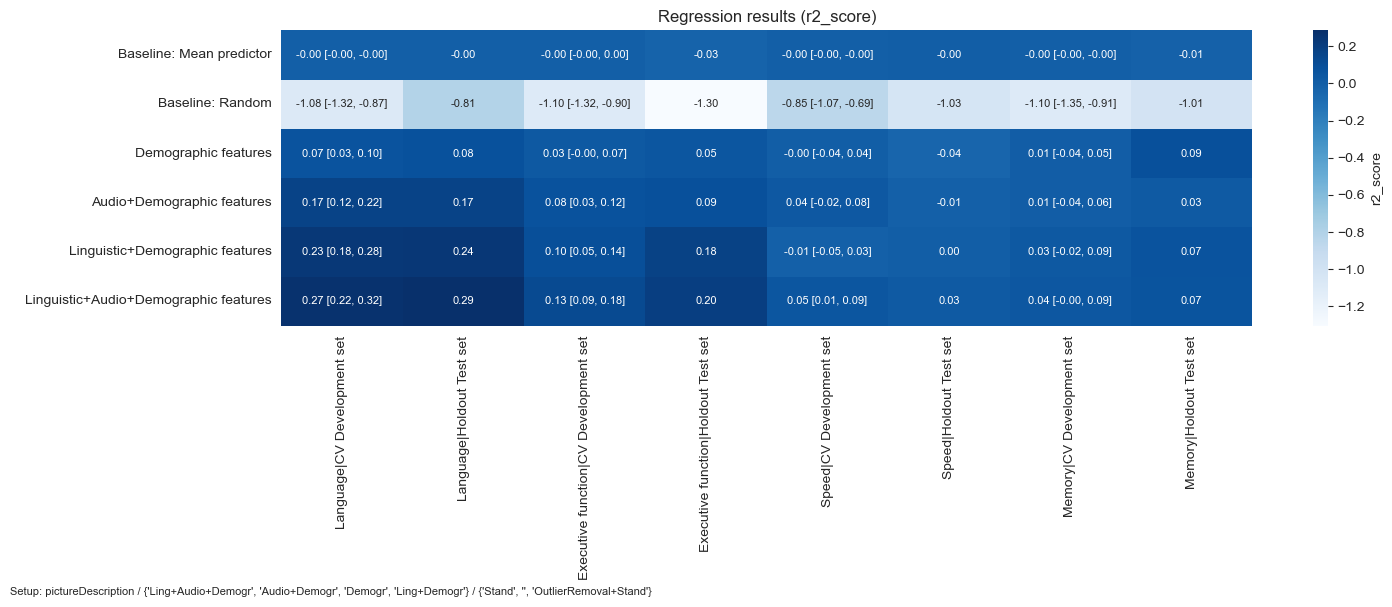

[{'pictureDescription'}] [{'Ling+Audio+Demogr', 'Audio+Demogr', 'Demogr', 'Ling+Demogr'}, {'Stand', '', 'OutlierRemoval+Stand'}]
Index(['Executive function|CV Development set', 'Speed|CV Development set',
       'Memory|CV Development set', 'Language|CV Development set',
       'Speed|Holdout Test set', 'Memory|Holdout Test set',
       'Executive function|Holdout Test set', 'Language|Holdout Test set'],
      dtype='object')


Language                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               -0.07 [-0.13, -0.00]              nan   
Baseline: Random                        -0.01 [-0.10, 0.05]             0.09   
Demographic features                      0.25 [0.18, 0.31]             0.26   
Audio+Demographic features                0.39 [0.32, 0.44]             0.41   
Linguistic+Demographic features           0.45 [0.39, 0.50]             0.43   
Linguistic+Audio+Demographic features     0.50 [0.44, 0.55]             0.50   

                                        Executive function                   \
                                        CV Development set Holdout Test set   
Baseline: Mean predictor               -0.07 [-0.13, 0.01]              nan   
Baseline: Random                       -0.02 [-0.09, 0.05]             0.03   
Demographic features                     0.20 [0.14, 0.26]             0.24   
Audio+Demographic features               0.27 [0.20, 0.33]             0.34   
Linguistic+Demographic features          0.31 [0.25, 0.37]             0.42   
Linguistic+Audio+Demographic features    0.35 [0.29, 0.41]             0.45   

                                                     Speed                   \
                                        CV Development set Holdout Test set   
Baseline: Mean predictor               -0.06 [-0.13, 0.01]              nan   
Baseline: Random                        0.05 [-0.01, 0.12]             0.10   
Demographic features                     0.13 [0.06, 0.20]             0.08   
Audio+Demographic features               0.27 [0.19, 0.32]             0.26   
Linguistic+Demographic features          0.17 [0.10, 0.22]             0.21   
Linguistic+Audio+Demographic features    0.27 [0.21, 0.33]             0.28   

                                                    Memory                   
                                        CV Development set Holdout Test set  
Baseline: Mean predictor               -0.07 [-0.13, 0.00]              nan  
Baseline: Random                        0.01 [-0.06, 0.08]            -0.01  
Demographic features                     0.20 [0.13, 0.26]             0.38  
Audio+Demographic features               0.22 [0.16, 0.28]             0.28  
Linguistic+Demographic features          0.22 [0.15, 0.30]             0.31  
Linguistic+Audio+Demographic features    0.25 [0.18, 0.31]             0.29

\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{2}{r}{Language} & \multicolumn{2}{r}{Executive function} & \multicolumn{2}{r}{Speed} & \multicolumn{2}{r}{Memory} \\
 & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set \\
\midrule
Baseline: Mean predictor & -0.07 [-0.13, -0.00] & nan & -0.07 [-0.13, 0.01] & nan & -0.06 [-0.13, 0.01] & nan & -0.07 [-0.13, 0.00] & nan \\
Baseline: Random & -0.01 [-0.10, 0.05] & 0.09 & -0.02 [-0.09, 0.05] & 0.03 & 0.05 [-0.01, 0.12] & 0.10 & 0.01 [-0.06, 0.08] & -0.01 \\
Demographic features & 0.25 [0.18, 0.31] & 0.26 & 0.20 [0.14, 0.26] & 0.24 & 0.13 [0.06, 0.20] & 0.08 & 0.20 [0.13, 0.26] & 0.38 \\
Audio+Demographic features & 0.39 [0.32, 0.44] & 0.41 & 0.27 [0.20, 0.33] & 0.34 & 0.27 [0.19, 0.32] & 0.26 & 0.22 [0.16, 0.28] & 0.28 \\
Linguistic+Demographic features & 0.45 [0.39, 0.50] & 0.43 & 0.31 [0.25, 0.37] & 0.42 & 0.17 [0.10, 0.22] & 0.21

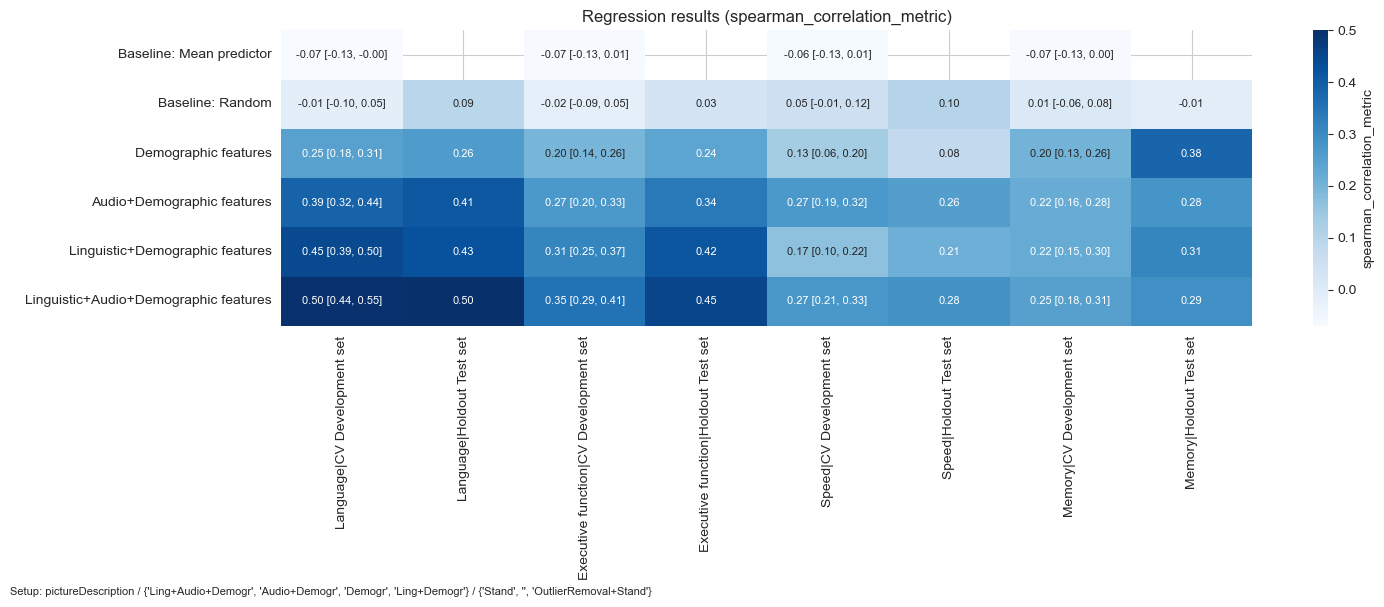

[{'pictureDescription'}] [{'Ling+Audio+Demogr', 'Audio+Demogr', 'Demogr', 'Ling+Demogr'}, {'Stand', '', 'OutlierRemoval+Stand'}]
Index(['Executive function|CV Development set', 'Speed|CV Development set',
       'Memory|CV Development set', 'Language|CV Development set',
       'Speed|Holdout Test set', 'Memory|Holdout Test set',
       'Executive function|Holdout Test set', 'Language|Holdout Test set'],
      dtype='object')


Language                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               25.07 [25.00, 25.17]            25.17   
Baseline: Random                       33.57 [31.95, 35.36]            30.74   
Demographic features                   23.92 [23.18, 24.64]            23.96   
Audio+Demographic features             22.43 [21.51, 23.40]            21.74   
Linguistic+Demographic features        21.59 [20.68, 22.64]            21.85   
Linguistic+Audio+Demographic features  20.88 [19.90, 21.87]            20.47   

                                         Executive function                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               25.38 [25.09, 25.85]            27.80   
Baseline: Random                       33.60 [32.08, 35.37]            34.34   
Demographic features                   24.52 [23.90, 25.09]            24.90   
Audio+Demographic features             24.14 [23.31, 24.96]            23.30   
Linguistic+Demographic features        23.32 [22.52, 24.18]            22.93   
Linguistic+Audio+Demographic features  22.93 [22.13, 23.83]            22.12   

                                                      Speed                   \
                                         CV Development set Holdout Test set   
Baseline: Mean predictor               25.35 [25.09, 25.90]            25.23   
Baseline: Random                       32.18 [30.61, 33.90]            32.61   
Demographic features                   24.97 [24.38, 25.55]            25.70   
Audio+Demographic features             24.12 [23.42, 24.99]            24.08   
Linguistic+Demographic features        25.10 [24.36, 25.80]            24.68   
Linguistic+Audio+Demographic features  24.07 [23.38, 24.81]            23.45   

                                                     Memory                   
                                         CV Development set Holdout Test set  
Baseline: Mean predictor               25.23 [25.05, 25.63]            25.14  
Baseline: Random                       33.06 [31.30, 34.79]            34.44  
Demographic features                   24.26 [23.62, 24.97]            22.77  
Audio+Demographic features             24.35 [23.52, 25.06]            24.17  
Linguistic+Demographic features        24.13 [23.24, 24.92]            23.49  
Linguistic+Audio+Demographic features  23.71 [22.91, 24.48]            23.77

\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{2}{r}{Language} & \multicolumn{2}{r}{Executive function} & \multicolumn{2}{r}{Speed} & \multicolumn{2}{r}{Memory} \\
 & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set \\
\midrule
Baseline: Mean predictor & 25.07 [25.00, 25.17] & 25.17 & 25.38 [25.09, 25.85] & 27.80 & 25.35 [25.09, 25.90] & 25.23 & 25.23 [25.05, 25.63] & 25.14 \\
Baseline: Random & 33.57 [31.95, 35.36] & 30.74 & 33.60 [32.08, 35.37] & 34.34 & 32.18 [30.61, 33.90] & 32.61 & 33.06 [31.30, 34.79] & 34.44 \\
Demographic features & 23.92 [23.18, 24.64] & 23.96 & 24.52 [23.90, 25.09] & 24.90 & 24.97 [24.38, 25.55] & 25.70 & 24.26 [23.62, 24.97] & 22.77 \\
Audio+Demographic features & 22.43 [21.51, 23.40] & 21.74 & 24.14 [23.31, 24.96] & 23.30 & 24.12 [23.42, 24.99] & 24.08 & 24.35 [23.52, 25.06] & 24.17 \\
Linguistic+Demographic features & 21.59 [20.68, 22.64] & 21.

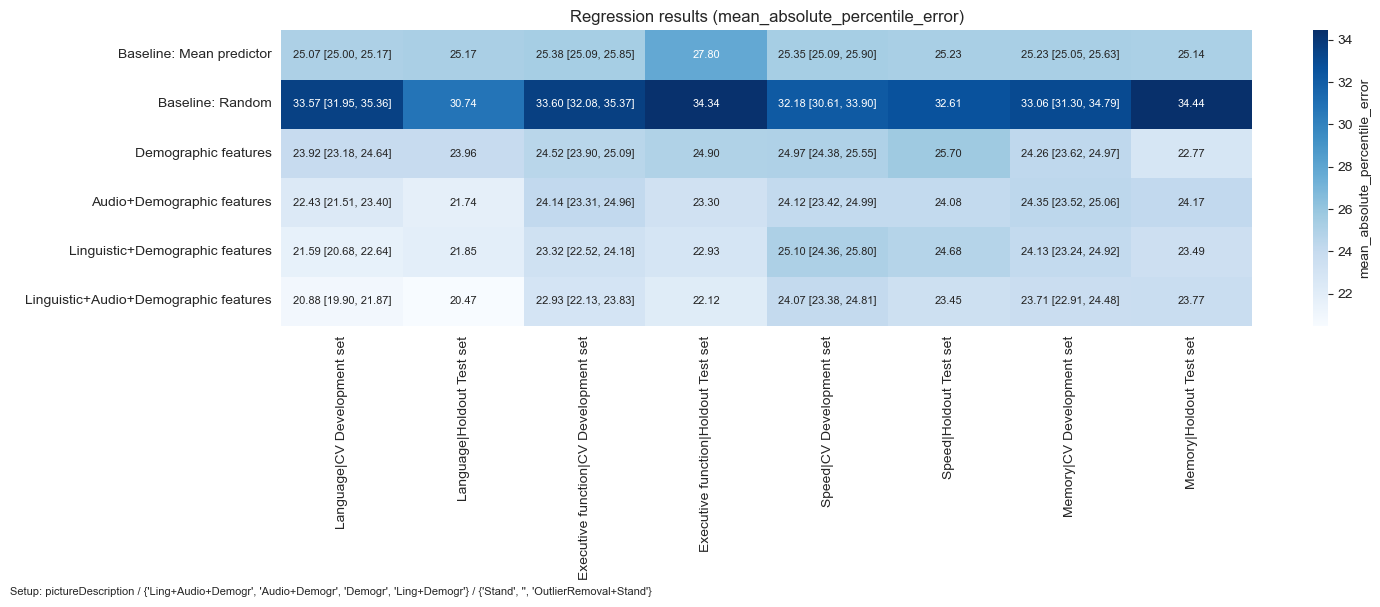

[{'pictureDescription'}] [{'Ling+Audio+Demogr', 'Audio+Demogr', 'Demogr', 'Ling+Demogr'}, {'Stand', '', 'OutlierRemoval+Stand'}]
Index(['Executive function|CV Development set', 'Speed|CV Development set',
       'Memory|CV Development set', 'Language|CV Development set',
       'Speed|Holdout Test set', 'Memory|Holdout Test set',
       'Executive function|Holdout Test set', 'Language|Holdout Test set'],
      dtype='object')


Language                   \
                                      CV Development set Holdout Test set   
Baseline: Mean predictor               0.79 [0.75, 0.83]             0.79   
Baseline: Random                       1.14 [1.08, 1.21]             1.03   
Demographic features                   0.76 [0.72, 0.80]             0.76   
Audio+Demographic features             0.72 [0.68, 0.76]             0.70   
Linguistic+Demographic features        0.69 [0.66, 0.73]             0.69   
Linguistic+Audio+Demographic features  0.68 [0.64, 0.72]             0.66   

                                      Executive function                   \
                                      CV Development set Holdout Test set   
Baseline: Mean predictor               0.81 [0.77, 0.86]             0.75   
Baseline: Random                       1.16 [1.09, 1.22]             1.06   
Demographic features                   0.79 [0.75, 0.84]             0.69   
Audio+Demographic features             0.78 [0.74, 0.83]             0.66   
Linguistic+Demographic features        0.76 [0.71, 0.80]             0.65   
Linguistic+Audio+Demographic features  0.75 [0.71, 0.79]             0.63   

                                                   Speed                   \
                                      CV Development set Holdout Test set   
Baseline: Mean predictor               0.82 [0.77, 0.86]             0.74   
Baseline: Random                       1.09 [1.02, 1.15]             1.06   
Demographic features                   0.80 [0.76, 0.85]             0.76   
Audio+Demographic features             0.78 [0.74, 0.82]             0.72   
Linguistic+Demographic features        0.81 [0.76, 0.85]             0.72   
Linguistic+Audio+Demographic features  0.78 [0.74, 0.82]             0.70   

                                                  Memory                   
                                      CV Development set Holdout Test set  
Baseline: Mean predictor               0.81 [0.77, 0.85]             0.83  
Baseline: Random                       1.13 [1.07, 1.19]             1.17  
Demographic features                   0.78 [0.74, 0.83]             0.76  
Audio+Demographic features             0.78 [0.74, 0.83]             0.81  
Linguistic+Demographic features        0.78 [0.73, 0.82]             0.78  
Linguistic+Audio+Demographic features  0.77 [0.72, 0.81]             0.79

\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{2}{r}{Language} & \multicolumn{2}{r}{Executive function} & \multicolumn{2}{r}{Speed} & \multicolumn{2}{r}{Memory} \\
 & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set & CV Development set & Holdout Test set \\
\midrule
Baseline: Mean predictor & 0.79 [0.75, 0.83] & 0.79 & 0.81 [0.77, 0.86] & 0.75 & 0.82 [0.77, 0.86] & 0.74 & 0.81 [0.77, 0.85] & 0.83 \\
Baseline: Random & 1.14 [1.08, 1.21] & 1.03 & 1.16 [1.09, 1.22] & 1.06 & 1.09 [1.02, 1.15] & 1.06 & 1.13 [1.07, 1.19] & 1.17 \\
Demographic features & 0.76 [0.72, 0.80] & 0.76 & 0.79 [0.75, 0.84] & 0.69 & 0.80 [0.76, 0.85] & 0.76 & 0.78 [0.74, 0.83] & 0.76 \\
Audio+Demographic features & 0.72 [0.68, 0.76] & 0.70 & 0.78 [0.74, 0.83] & 0.66 & 0.78 [0.74, 0.82] & 0.72 & 0.78 [0.74, 0.83] & 0.81 \\
Linguistic+Demographic features & 0.69 [0.66, 0.73] & 0.69 & 0.76 [0.71, 0.80] & 0.65 & 0.81 [0.76, 0.85] & 0.72 & 0.78 [0.7

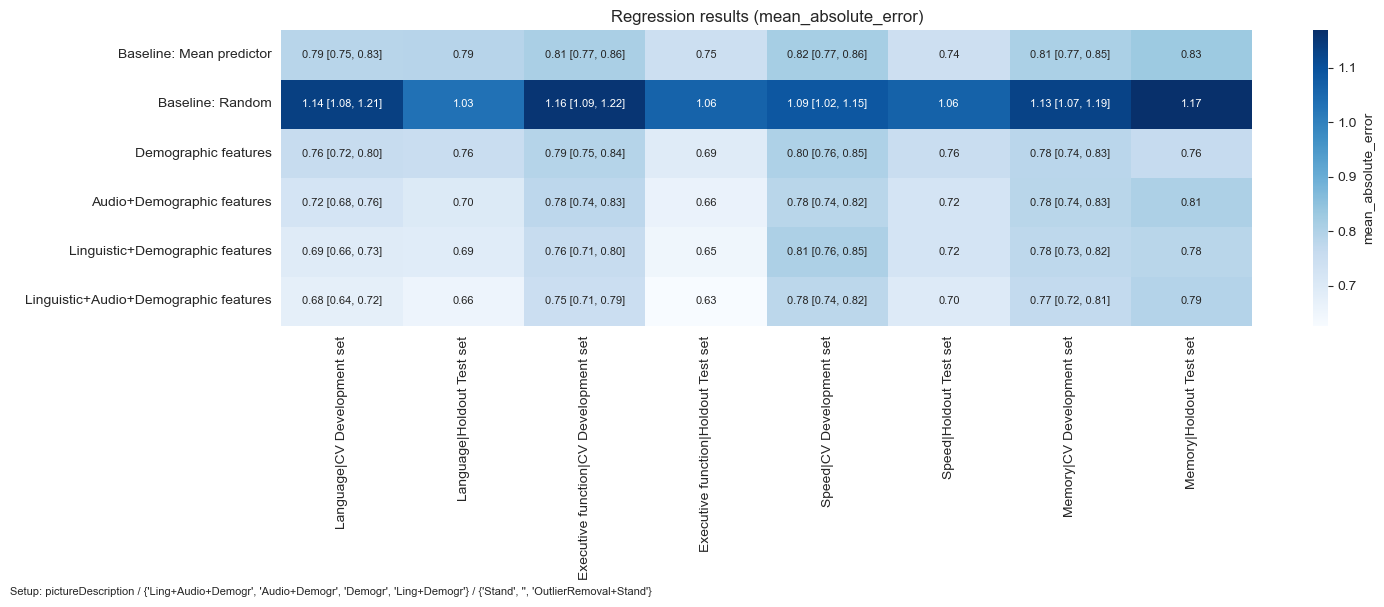

In [60]:
plot_results(scores, 'r2_score')
plot_results(scores, 'spearman_correlation_metric')
plot_results(scores, 'mean_absolute_percentile_error')
plot_results(scores, 'mean_absolute_error')
#plot_results(scores, 'explained_variance_score')
#plot_results(scores, 'pearson_correlation_metric')




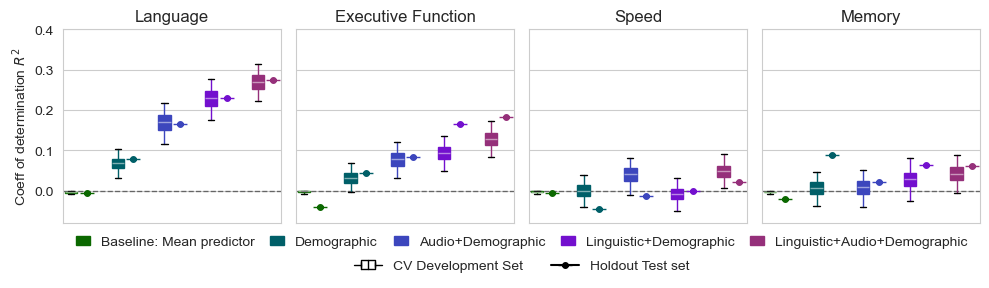

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.legend_handler import HandlerBase
import matplotlib
from copy import copy
#from util.helpers import composite_target_to_string_mapping as target_mapping 
target_mapping = {'composite_speed': 'Speed', 'composite_language': 'Language', 'composite_executive_function': 'Executive Function', 'composite_memory': 'Memory',
                                      'speed': 'Speed', 'language': 'Language', 'executive_function': 'Executive Function', 'memory': 'Memory'}

    
class HandlerBoxPlotHorizontal(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        a_list = []
        
        # horizontal box
        a_list.append(matplotlib.lines.Line2D(np.array([0.25, 0.75, 0.75, 0.25, 0.25])*width - xdescent,
                                              np.array([0, 0, 1, 1, 0])*height - ydescent, linewidth=1))
        
        # median line
        a_list.append(matplotlib.lines.Line2D(np.array([0.5, 0.5])*width - xdescent,
                                              np.array([0, 1])*height - ydescent, linewidth=1))
        
        # left whisker
        a_list.append(matplotlib.lines.Line2D(np.array([0, 0.25])*width - xdescent,
                                              np.array([0.5, 0.5])*height - ydescent, linewidth=1))
        
        # right whisker
        a_list.append(matplotlib.lines.Line2D(np.array([0.75, 1])*width - xdescent,
                                              np.array([0.5, 0.5])*height - ydescent, linewidth=1))
        
        # left vertical line (at minimum)
        a_list.append(matplotlib.lines.Line2D(np.array([0.25, 0.25])*width - xdescent,
                                              np.array([0.25, 0.75])*height - ydescent, linewidth=1))
        
        # right vertical line (at maximum)
        a_list.append(matplotlib.lines.Line2D(np.array([0.75, 0.75])*width - xdescent,
                                              np.array([0.25, 0.75])*height - ydescent, linewidth=1))
        
        for a in a_list:
            a.set_color('black')
        return a_list


# Define a custom marker path
def create_custom_marker():
    # Vertices for the horizontal line and the circle
    vertices = [(-1, 0), (1, 0)]  # Endpoints of the line
    codes = [Path.MOVETO, Path.LINETO]
    
    # Add a circle manually by adding points around a center
    circle_radius = 0.4
    num_circle_points = 20  # More points make the circle smoother
    for i in range(num_circle_points + 1):  # +1 to close the circle
        angle = 2 * np.pi * i / num_circle_points
        x = np.cos(angle) * circle_radius
        y = np.sin(angle) * circle_radius
        vertices.append((x, y))
        if i == 0:
            codes.append(Path.MOVETO)  # Start the circle
        else:
            codes.append(Path.LINETO)  # Continue the circle

    # Close the circle
    codes.append(Path.CLOSEPOLY)
    vertices.append((0, 0))  # Close path dummy point (not used)

    return Path(vertices, codes)


def plot_results_new(scores, metric):
    #metric = 'explained_variance_score'
    #metric = 'r2_score'
    #metric = 'mean_absolute_error'
    #metric = 'spearman_correlation_metric'
    
    fig = plt.figure(figsize=(10, 3))
    gs = GridSpec(3, 4, height_ratios=(8, 1, 1), figure=fig)
    gs.update(hspace=0.0) # set the spacing between axes. 
    axes = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[0, 3]),
    ]
    legend_axis = fig.add_subplot(gs[1, :])
    legend_axis2 = fig.add_subplot(gs[2, :])
    
    data_to_plot = defaultdict(dict)
    non_plotting_dimensions_collected = list()
    ignore_dimensions_collected = list()
    for parameter_string in scores.keys():
        split_parameter_string = parameter_string.split(" - ")
        model_name, task, target, data_transformers, data_preprocessors, setup_version, feature_groups = split_parameter_string
        
        x_grouping = [target,model_name, feature_groups]
        y_grouping = [setup_version]
        ignore_dimensions = [data_transformers, data_preprocessors]  # can be different, but not in x_grouping / y_grouping
        x_grouping_str, y_grouping_str = "|".join(x_grouping), "|".join(y_grouping)
        
        x_grouping_str = x_grouping_str.replace("SVR|dem", "Demographic features").replace("SVR|lit|csunghye|dem", "Linguistic+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|dem", "Audio+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|lit|csunghye|dem", "Linguistic+Audio+Demographic features").replace("MeanPrediction|dem", "Baseline: Mean predictor").replace("RandomSampling|dem", "Baseline: Random Sampling")
        x_grouping_str = x_grouping_str.replace("SVR|dem", "Demographic features").replace("SVR|lit|csunghye|dem", "Linguistic+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|dem", "Audio+Demographic features").replace("SVR|pause|phoneme|eGeMAPS|lit|csunghye|dem", "Linguistic+Audio+Demographic features").replace("MeanPrediction|dem", "Baseline: Mean predictor").replace("RandomSampling|dem", "Baseline: Random Sampling")
        y_grouping_str = y_grouping_str.replace("CV train", "CV Development set").replace("train/test", "Holdout Test set")
        
        
        data_to_plot[x_grouping_str][y_grouping_str] = scores[parameter_string][0][metric]['bootstrap_distribution']
        
        non_plotting_dimensions = [dim for dim in split_parameter_string if dim not in x_grouping + y_grouping + ignore_dimensions]
        non_plotting_dimensions_collected.append(non_plotting_dimensions)
        ignore_dimensions_collected.append(ignore_dimensions)
    
    
    non_plotting_dimensions_set = [set([row[i] for row in non_plotting_dimensions_collected]) for i in range(len(non_plotting_dimensions_collected[0]))]
    if any([len(dim) > 1 for dim in non_plotting_dimensions_set]):
        raise ValueError("Non-plotting dimensions should be the same in all settings, but they are not:", non_plotting_dimensions_set)
    ignore_dimensions_set = [set([row[i] for row in ignore_dimensions_collected]) for i in range(len(ignore_dimensions_collected[0]))]
    #print(non_plotting_dimensions_set, ignore_dimensions_set)
    non_plotting_dimensions_str = " / ".join([str(dim) if len(dim)>1 else list(dim)[0] for dim in non_plotting_dimensions_set+ignore_dimensions_set])
    
    
    def custom_sort_order(val):
        split_val = val.split("|")
        key1 = split_val[0]
        if 'Baseline' in val: 
            sorting = 0
        else: 
            sorting = len(val)
        return f"{key1}{sorting}"
        
    data_to_plot_df = pd.DataFrame(data_to_plot)
    data_to_plot_df = data_to_plot_df[sorted(data_to_plot_df.columns, key=custom_sort_order)].sort_index()
    #data_to_plot_df_pivoted = data_to_plot_df.reset_index().melt(id_vars=['index'], value_vars=data_to_plot_df.columns)
    #data_to_plot_df_pivoted_exploded = data_to_plot_df_pivoted.explode(column='value')
    #display(data_to_plot_df)
           
           


    #palette = {'setosa': 'crimson', 'versicolor': 'cornflowerblue', 'virginica': 'limegreen'}
    #elements = sns.violinplot(ax=ax, data=data_to_plot_df_pivoted_exploded, inner=None, density_norm='width', x='variable', y='value', hue='index', split=False) # palette=palette
    
    versions = ['CV Development set', 'Holdout Test set']
    colors = {
        #'CV Development set': '#6D435A',
        #'Holdout Test set': '#EAB464',
        'CV Development set': '#555',
        'Holdout Test set': '#000',
    } 
    
    # colors from https://medium.com/wttj-tech/how-we-designed-an-accessible-color-palette-from-scratch-f29ec603bd7f
    colors = {
        'Baseline: Mean predictor': '#0B6800',
        'Demographic': '#005F68',
        'Audio+Demographic': '#3C46BD',
        'Linguistic+Demographic': '#7310CE',
        'Linguistic+Audio+Demographic': '#95307A',
    }
    
    #display(data_to_plot_df)
    y_range = []
    
    
    for target, ax, target_idx in zip(['language', 'executive_function', 'speed', 'memory', ], axes, range(4)):
        if metric not in ['mean_absolute_percentile_error', 'mean_absolute_error', 'mean_squared_error']:
            ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_title(target_mapping[target])
        data_subset = data_to_plot_df[[c for c in data_to_plot_df.columns if target in c]]
        #display(data_subset)
        all_bplots = []
        all_xlabels = []
        for version_idx, version in enumerate(versions):
            data_subset_version = data_subset.loc[[version]]
            #display(data_subset_version)
            for x_idx, x in enumerate(data_subset_version.columns):
                position = x_idx*3+version_idx
                #print(version, x, position)
                x_label = x.replace(f"composite_{target}|","").replace(" features", "")
                all_xlabels.append(x_label)
                if version == 'Holdout Test set':
                    # show invisible boxes, for label logic
                    bplot = ax.boxplot(data_subset_version[x], positions=[position], labels=[x_label], showfliers=False, whiskerprops={'color': '#fff0'}, showcaps=False, showbox=False, medianprops={'color': '#fff0'})
                    all_bplots.append(bplot)
                    # show custom marker for mean
                    traintest_plot = ax.plot([position], [data_subset_version[x].explode().mean()], marker=create_custom_marker(), c=colors.get(x_label, 'black'), markersize=10)
                else:
                    bplot = ax.boxplot(data_subset_version[x], positions=[position], labels=[x_label], widths=0.8, patch_artist=True, showfliers=False, whis=(2.5, 97.5))
                    all_bplots.append(bplot)
                    boxes = bplot['boxes']
                    whiskers = bplot['whiskers']
                    [p.set(facecolor=colors.get(x_label, 'black')) for p in boxes]
                    [p.set(color=colors.get(x_label, 'black')) for p in boxes]
                    [p.set(color=colors.get(x_label, 'black')) for p in whiskers]
                    medians = bplot['medians']
                    [p.set(color='white', alpha=0.5) for p in medians]
                
                
        ax.tick_params(axis='x', labelrotation=90)
        #[l.set_ha('right') for l in ax.get_xticklabels()]
        #[l.set_rotation_mode('anchor') for l in ax.get_xticklabels()]
        
        x_ticks = ax.get_xticks()
        x_ticklabels = [l.get_text() for l in ax.get_xticklabels()]
        x_ticks_df = pd.DataFrame({'tick': x_ticks, 'label': x_ticklabels})
        def create_new_ticks(group):
            assert group.shape[0] == 2
            assert group.max() - group.min() == 1
            return pd.Series({'tick': group.mean()})
        new_ticks = x_ticks_df.groupby('label').agg(create_new_ticks).reset_index()
        ax.set_xticks(new_ticks['tick'], new_ticks['label'])
        ax.grid(False, axis='x', )
        ax.set_xticks([])

            
        if target_idx == 0:
            ax.set_ylabel(metric.replace("r2_score", r'Coeff of determination $R^2$'))
        else:
            ax.tick_params(axis='y', labelleft=False)
                        
        y_range.append(ax.get_ylim())
        
        
    
    # unify y ranges
    y_lim_unified = pd.DataFrame(y_range)[0].min(), pd.DataFrame(y_range)[1].max()
    for ax in axes:
        #ax.set_ylim(y_lim_unified)
        ax.set_ylim([-0.08, 0.4])
        
    legend_axis.legend([all_bplots[0]["boxes"][0], all_bplots[1]["boxes"][0], all_bplots[2]["boxes"][0], all_bplots[3]["boxes"][0], all_bplots[4]["boxes"][0]], all_xlabels + ['test set'], loc='upper center', ncols=6, columnspacing=0.2, mode='expand', handlelength=1, frameon=False)
    legend_axis.set_axis_off()

    legend_elem_cv = all_bplots[0]["boxes"][0]
    legend_elem_traintest = legend_axis2.plot([0], [0], marker=create_custom_marker(), c='black', markersize=10)[0]
    legend_axis2.legend([legend_elem_cv, legend_elem_traintest], ['CV Development Set', 'Holdout Test set'], loc='upper center', ncols=2, columnspacing=2, frameon=False, handler_map={legend_elem_cv:HandlerBoxPlotHorizontal()})  
    legend_axis2.set_ylim((10, 11))
    legend_axis2.set_axis_off()

                
   # plt.title(f"Regression results ({metric})")    
    plt.tight_layout()
    plt.savefig("plots/regression_results.pdf")
    plt.show()
    
    
    
scores_without_random_sampling = {param: score for param, score in scores.items() if 'RandomSampling' not in param}
plot_results_new(scores_without_random_sampling, 'r2_score')  
#, 'spearman_correlation_metric', 'mean_absolute_percentile_error'
# , 'spearman_correlation_metric', 'mean_absolute_percentile_error', 'explained_variance_score', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error' 'pearson_correlation_metric'


In [32]:
# statistical analysis: is demographic+linguistic+acoustic significantly better than just demographic?

scores

defaultdict(<function __main__.<lambda>()>,
            {'SVR - pictureDescription - composite_executive_function - Demogr - Stand - CV train - dem': [{'spearman_correlation_metric': {'score': 0.19865395951849268,
                'ci_low': 0.13783956442570106,
                'ci_high': 0.2646801716924876,
                'bootstrap_distribution': array([0.14674738, 0.2047446 , 0.23004916, 0.15972229, 0.20667872,
                       0.24154235, 0.22474011, 0.1632185 , 0.22450682, 0.21245233,
                       0.24497333, 0.23625021, 0.22134358, 0.26013376, 0.16410775,
                       0.16973221, 0.16595528, 0.24773873, 0.17956205, 0.16409497,
                       0.2154728 , 0.27074266, 0.26716095, 0.20845603, 0.18755587,
                       0.20116405, 0.21373014, 0.25675364, 0.20192229, 0.2328792 ,
                       0.14811185, 0.27243301, 0.19281582, 0.19211271, 0.20240478,
                       0.15605329, 0.21938294, 0.17977869, 0.15428279, 0.20687572,
  

In [34]:




def bootstrap_significance_test(results_dir1, results_dir2, metric, target_variable):
    # results 1:
    prediction_and_target1 = pd.read_csv(os.path.join(results_dir1, "prediction_and_target.csv"))
    sample_names1 = prediction_and_target1['sample_name']
    #prediction_and_target1.set_index('sample_name', inplace=True)
    
    # results 2
    prediction_and_target2 = pd.read_csv(os.path.join(results_dir2, "prediction_and_target.csv"))
    sample_names2 = prediction_and_target2['sample_name']
    #prediction_and_target2.set_index('sample_name', inplace=True)

    # intersection of sample names (can be difference of low number of people, due to missing values etc.)
    # then make sure both dataframes contain these sample names in this order
    sample_names = sorted(list(set(sample_names1).intersection(set(sample_names2))))
    prediction_and_target1 = prediction_and_target1.set_index('sample_name').loc[sample_names, :]
    prediction_and_target2 = prediction_and_target2.set_index('sample_name').loc[sample_names, :]
    predictions1, targets1 = prediction_and_target1['prediction'], prediction_and_target1[target_variable]
    predictions2, targets2 = prediction_and_target2['prediction'], prediction_and_target2[target_variable]
    
    def score_difference(predictions1, targets1, predictions2, targets2):
        metric1 = metric(targets1, predictions1)
        metric2 = metric(targets2, predictions2)
        diff = metric2 - metric1
        return (metric1, metric2, diff)
    
    # draw samples
    bootstrap_results = bootstrap((predictions1, targets1, predictions2, targets2), score_difference, n_resamples=1000, paired=True, random_state=123)
    
    return {
        'Target variable': target_mapping[target_variable], 
        #'result_1': f"{bootstrap_results.confidence_interval.low[0]:.2f} - {bootstrap_results.confidence_interval.high[0]:.2f}", 
        #'result_2': f"{bootstrap_results.confidence_interval.low[1]:.2f} - {bootstrap_results.confidence_interval.high[1]:.2f}", 
        'Performance increase (95% Confidence interval)': f"{bootstrap_results.confidence_interval.low[2]:.2f} - {bootstrap_results.confidence_interval.high[2]:.2f}",
        'Significant finding': bootstrap_results.confidence_interval.low[2] > 0 and bootstrap_results.confidence_interval.high[2] > 0,
    }




targets = ['composite_language', 'composite_executive_function', 'composite_speed', 'composite_memory']
metric_name = 'r2_score'
metric = sk_metrics.r2_score

statistical_test_results = []
for target_variable in targets:
    parameter_string_demographics_only = f"SVR - pictureDescription - {target_variable} - Demogr - Stand - CV train - dem"
    parameter_string_full = f"SVR - pictureDescription - {target_variable} - Ling+Audio+Demogr - OutlierRemoval+Stand - CV train - pause|phoneme|eGeMAPS|lit|csunghye|dem"
    
    results_dir_demographics_only = scores[parameter_string_demographics_only][0][metric_name]['results_dir']
    results_dir_full = scores[parameter_string_full][0][metric_name]['results_dir']
    # note that due to the random_seed parameter, the boostrap distribution will
    statistical_test_results.append(bootstrap_significance_test(results_dir_demographics_only, results_dir_full, metric, target_variable))
    


statistical_test_results_df = pd.DataFrame(statistical_test_results)
statistical_test_results_df


Target variable Performance increase (95% Confidence interval)  \
0            Language                                    0.15 - 0.24   
1  Executive Function                                    0.05 - 0.14   
2               Speed                                    0.01 - 0.10   
3              Memory                                   -0.02 - 0.08   

   Significant finding  
0                 True  
1                 True  
2                 True  
3                False

In [61]:
print(statistical_test_results_df.to_latex(index=False))

\begin{tabular}{llr}
\toprule
Target variable & Performance increase (95% Confidence interval) & Significant finding \\
\midrule
Language & 0.15 - 0.24 & True \\
Executive Function & 0.05 - 0.14 & True \\
Speed & 0.01 - 0.10 & True \\
Memory & -0.02 - 0.08 & False \\
\bottomrule
\end{tabular}

